# Visualizing ElastiSim results

## Required libraries: [pandas](https://pandas.pydata.org/) and [Plotly](https://plotly.com/)

In [1]:
import pandas as pd
import plotly.express as px

## Visulization functions

### Returns a pandas dataframe containing all jobs and corresponding details

*input_path*: path to job statistics file

In [2]:
def read_job_statistics(input_path):
    job_statistics = pd.read_csv(input_path, index_col='ID')
    job_statistics['Submit Time'] = job_statistics['Submit Time'] / 60
    job_statistics['Start Time'] = job_statistics['Start Time'] / 60
    job_statistics['End Time'] = job_statistics['End Time'] / 60
    job_statistics['Wait Time'] = job_statistics['Wait Time'] / 60
    job_statistics['Turnaround Time'] = job_statistics['Turnaround Time'] / 60
    job_statistics['Makespan'] = job_statistics['Makespan'] / 60
    return job_statistics

### Plots the node utilization as a Gantt chart

*input_path*: path to node utilization file

*output_path* (optional): path to output image

In [3]:
def plot_node_utilization(input_path, indicate_job_ids=False, output_path=False):
    node_utilization = pd.read_csv(input_path)
    node_utilization['Time'] = node_utilization['Time'] / 60
    groups = []
    for group in node_utilization.groupby('Node', sort=False):
        node_states = group[1].rename(columns={'Time': 'Start Time'})
        node_states['End Time'] = node_states.shift(-1)['Start Time']
        groups.append(node_states)
    node_utilization = pd.concat(groups)

    job_ids = node_utilization['Running jobs'].unique()
    if indicate_job_ids:
        fig = px.timeline(node_utilization, x_start='Start Time', x_end='End Time', y='Node',
                          color='Running jobs', color_discrete_sequence=px.colors.qualitative.Alphabet,
                          opacity=0.8, labels={"Node": "Compute Node"}, title='Node Utilization', text='Running jobs')
    else:
        fig = px.timeline(node_utilization, x_start='Start Time', x_end='End Time', y='Node',
                          color='Running jobs', color_discrete_sequence=px.colors.qualitative.Alphabet,
                          opacity=0.8, labels={"Node": "Compute Node"}, title='Node Utilization')
    i = 0
    for job_id in job_ids:
        if job_id == 'none':
            i += 1
            continue
        else:
            job_utilization_per_id = node_utilization[node_utilization['Running jobs'] == job_id]
            fig.data[i].x = job_utilization_per_id['End Time'] - job_utilization_per_id['Start Time']
            i += 1
    fig.update_xaxes(type='linear', title='Time (m)')
    fig.update_yaxes(autorange='reversed')
    fig.update_layout(bargap=0, showlegend=False)
    fig.update_traces(marker_line_width=0, textangle=0)
    if output_path:
        fig.write_image(output_path)
    return fig

### Plots the system-wide CPU utilization

*input_path*: path to CPU utilization file

*start* (optional): start time of the plot in minutes

*end* (optional): start time of the plot in minutes

*window* (optional): window size of the rolling average (number of data points)

*output_path* (optional): path to output image

In [4]:
def plot_system_wide_cpu(input_path, start=False, end=False, window=1, output_path=False):
    cpu_utilization = pd.read_csv(input_path, index_col='Time')
    cpu_utilization.index = cpu_utilization.index / 60
    if start:
        cpu_utilization = cpu_utilization.loc[cpu_utilization.index >= start].dropna()
    if end:
        cpu_utilization = cpu_utilization.loc[cpu_utilization.index <= end].dropna()
    cpu_utilization = cpu_utilization.sum(axis=1) / len(cpu_utilization.columns)
    cpu_utilization *= 100
    cpu_utilization = pd.DataFrame({'CPU': cpu_utilization})
    if window > 1:
        cpu_utilization = cpu_utilization.rolling(window).mean()
    fig = px.line(cpu_utilization, labels={
        'Time': 'Time (m)',
        'value': 'Utilization [%]',
    }, title='System-wide CPU Utilization')
    fig.update_layout(showlegend=False)
    if output_path:
        fig.write_image(output_path)
    return fig

### Plots the system-wide network activity

*input_path*: path to network activity file

*start* (optional): start time of the plot in minutes

*end* (optional): start time of the plot in minutes

*window* (optional): window size of the rolling average (number of data points)

*output_path* (optional): path to output image

In [5]:
def plot_network_activity(input_path, start=False, end=False, window=1, output_path=False):
    network_activity = pd.read_csv(input_path, index_col='Time')
    network_activity.index = network_activity.index / 60
    if start:
        network_activity = network_activity.loc[network_activity.index >= start].dropna()
    if end:
        network_activity = network_activity.loc[network_activity.index <= end].dropna()
    network_activity *= 100
    if window > 1:
        network_activity = network_activity.rolling(window).mean()
    fig = px.line(network_activity, labels={
        'Time': 'Time (m)',
        'value': 'Activity [%]'
    }, title='Network Activity')
    fig.update_layout(showlegend=False)
    if output_path:
        fig.write_image(output_path)
    return fig

### Plots the PFS utilization

*input_path*: path to PFS utilization file

*start* (optional): start time of the plot in minutes

*end* (optional): start time of the plot in minutes

*window* (optional): window size of the rolling average (number of data points)

*output_path* (optional): path to output image

In [6]:
def plot_pfs_utilization(input_path, start=False, end=False, window=1, output_path=False):
    pfs_utilization = pd.read_csv(input_path, index_col='Time')
    pfs_utilization.index = pfs_utilization.index / 60
    if start:
        pfs_utilization = pfs_utilization.loc[pfs_utilization.index >= start].dropna()
    if end:
        pfs_utilization = pfs_utilization.loc[pfs_utilization.index <= end].dropna()
    pfs_utilization['Read'] = pfs_utilization['Read'] / 1024 / 1024 / 1024
    pfs_utilization = pfs_utilization.drop(columns=['Read (rel.)', 'Write (rel.)'])
    if window > 1:
        pfs_utilization['Read'] = pfs_utilization['Read'].rolling(window).mean()
    pfs_utilization['Write'] = pfs_utilization['Write'] / 1024 / 1024 / 1024
    if window > 1:
        pfs_utilization['Write'] = pfs_utilization['Write'].rolling(window).mean()
    fig = px.line(pfs_utilization, labels={
        'Time': 'Time (m)',
        'value': 'Bandwidth [GiB/s]',
        'variable': 'Link'
    }, title='PFS Utilization')
    if output_path:
        fig.write_image(output_path)
    return fig

### Plots a joint utilization plot comprising CPU utilization, network activity, and PFS utilization

*cpu_utilization_path*: path to CPU utilization file

*network_activity_path*: path to network activity file

*pfs_utilization_path*: path to PFS utilization file

*start* (optional): start time of the plot in minutes

*end* (optional): start time of the plot in minutes

*window* (optional): window size of the rolling average (number of data points)

*output_path* (optional): path to output image

In [7]:
def plot_utilization(cpu_utilization_path, network_activity_path, pfs_utilization_path, start=False, end=False,
                     window=1, output_path=False):
    cpu_utilization = pd.read_csv(cpu_utilization_path, index_col='Time')
    cpu_utilization.index = cpu_utilization.index / 60
    network_activity = pd.read_csv(network_activity_path, index_col='Time')
    network_activity.index = network_activity.index / 60
    pfs_utilization = pd.read_csv(pfs_utilization_path, index_col='Time')
    pfs_utilization.index = pfs_utilization.index / 60

    if start:
        cpu_utilization = cpu_utilization.loc[cpu_utilization.index >= start].dropna()
        network_activity = network_activity.loc[network_activity.index >= start].dropna()
        pfs_utilization = pfs_utilization.loc[pfs_utilization.index >= start].dropna()
    if end:
        cpu_utilization = cpu_utilization.loc[cpu_utilization.index <= end].dropna()
        network_activity = network_activity.loc[network_activity.index <= end].dropna()
        pfs_utilization = pfs_utilization.loc[pfs_utilization.index <= end].dropna()

    cpu_utilization = cpu_utilization.sum(axis=1) / len(cpu_utilization.columns)
    cpu_utilization = pd.DataFrame({'CPU': cpu_utilization})

    network_activity = network_activity.rename(columns={'Utilization': 'Network'})

    pfs_utilization = pfs_utilization.drop(columns=['Read', 'Write'])
    pfs_utilization = pfs_utilization.rename(columns={'Read (rel.)': 'PFS Read'})
    pfs_utilization = pfs_utilization.rename(columns={'Write (rel.)': 'PFS Write'})

    utilization = pd.concat([cpu_utilization, network_activity, pfs_utilization], axis=1)
    utilization = utilization * 100
    if window > 1:
        utilization['CPU'] = utilization['CPU'].rolling(window).mean()
        utilization['Network'] = utilization['Network'].rolling(window).mean()
        utilization['PFS Read'] = utilization['PFS Read'].rolling(window).mean()
        utilization['PFS Write'] = utilization['PFS Write'].rolling(window).mean()

    fig = px.line(utilization, labels={
        'Time': 'Time (m)',
        'value': 'Utilization [%]',
        'variable': 'Resource'
    }, title='System Utilization')
    if output_path:
        fig.write_image(output_path)
    return fig

### Plots a Gantt chart of running and waiting jobs

*input_path*: path to job statistics file

*output_path* (optional): path to output image

In [8]:
def plot_jobs_gantt(input_path, output_path=False):
    job_statistics = read_job_statistics(input_path)
    job_statistics['Job State'] = 'running'
    waiting_times = job_statistics.copy()
    waiting_times['Job State'] = 'waiting'
    waiting_times['Start Time'] = job_statistics['Submit Time']
    waiting_times['End Time'] = job_statistics['Start Time']
    waiting_times['Makespan'] = job_statistics['Wait Time']
    job_statistics = job_statistics.drop(columns=['Submit Time', 'Wait Time', 'Turnaround Time', 'Status'])
    waiting_times = waiting_times.drop(columns=['Submit Time', 'Wait Time', 'Turnaround Time', 'Status'])
    job_statistics = pd.concat([job_statistics, waiting_times])

    fig = px.timeline(job_statistics, x_start='Start Time', x_end='End Time', y=job_statistics.index, color='Job State',
                      title='Job Runtimes')
    fig.data[0].x = job_statistics['Makespan'].iloc[:len(job_statistics) // 2]
    fig.data[1].x = job_statistics['Makespan'].iloc[len(job_statistics) // 2:]
    fig.data[1].opacity = 0.5
    fig.update_xaxes(type='linear', title='Time (m)')
    fig.update_yaxes(autorange="reversed")
    fig.update_layout(bargap=0, legend={'bgcolor': 'rgba(255,255,255,0.2)'})
    fig.update_traces(marker_line_width=0)
    if output_path:
        fig.write_image(output_path)
    return fig

### Plots a box plot comprising the waiting time, makespan, and turnaround time

*input_path*: path to job statistics file

*output_path* (optional): path to output image

In [9]:
def plot_jobs_box(input_path, output_path=False):
    job_statistics = read_job_statistics(input_path)
    fig = px.box(job_statistics.drop(columns=['Type', 'Submit Time', 'Start Time', 'End Time', 'Status']), labels={
        'value': 'Time (m)',
        'variable': 'Variable'
    })
    if output_path:
        fig.write_image(output_path)
    return fig

### Plots a violin plot comprising the waiting time, makespan, and turnaround time

*input_path*: path to job statistics file

*output_path* (optional): path to output image

In [10]:
def plot_jobs_violin(input_path, output_path=False):
    job_statistics = read_job_statistics(input_path)
    fig = px.violin(job_statistics.drop(columns=['Type', 'Submit Time', 'Start Time', 'End Time', 'Status']), box=True,
                    labels={
                        'value': 'Time (m)',
                        'variable': 'Variable'
                    })
    if output_path:
        fig.write_image(output_path)
    return fig

## Example usage

In [11]:
import os

Note: replace *output_dir*

In [12]:
output_dir = '/path/to/example-project/data/output'

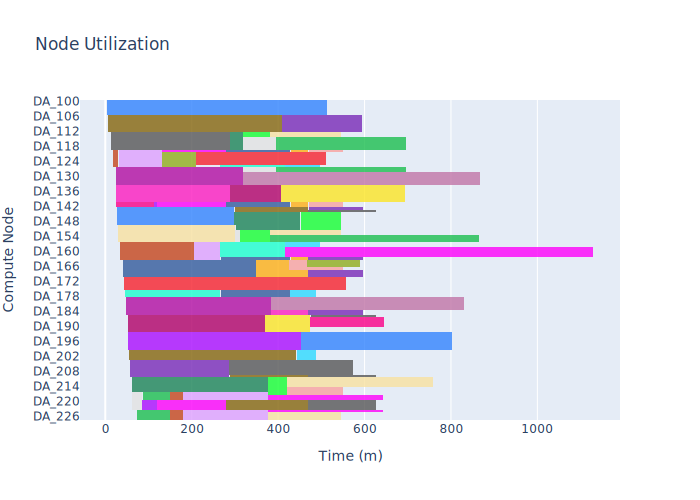

In [13]:
plot_node_utilization(os.path.join(output_dir, 'node_utilization.csv'))

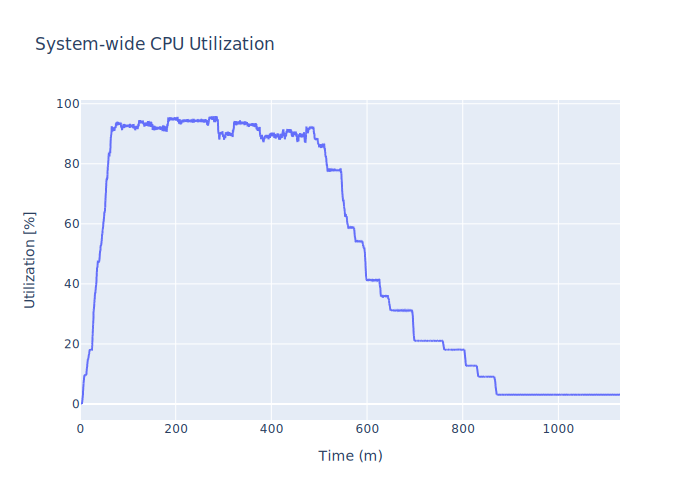

In [14]:
plot_system_wide_cpu(os.path.join(output_dir, 'cpu_utilization.csv'), window=200)

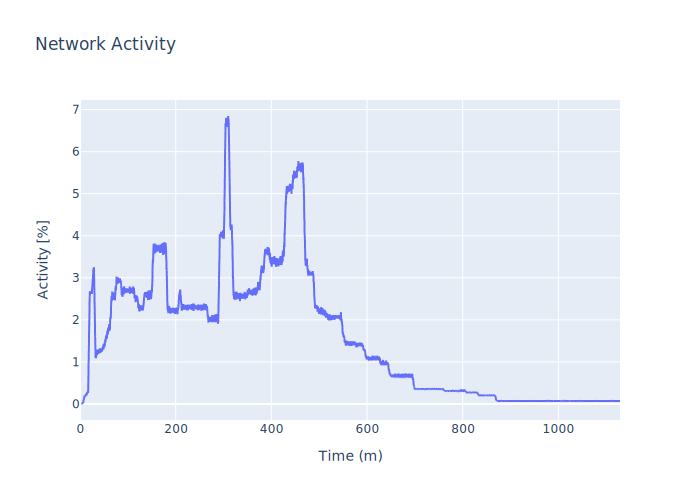

In [15]:
plot_network_activity(os.path.join(output_dir, 'network_activity.csv'), window=200)

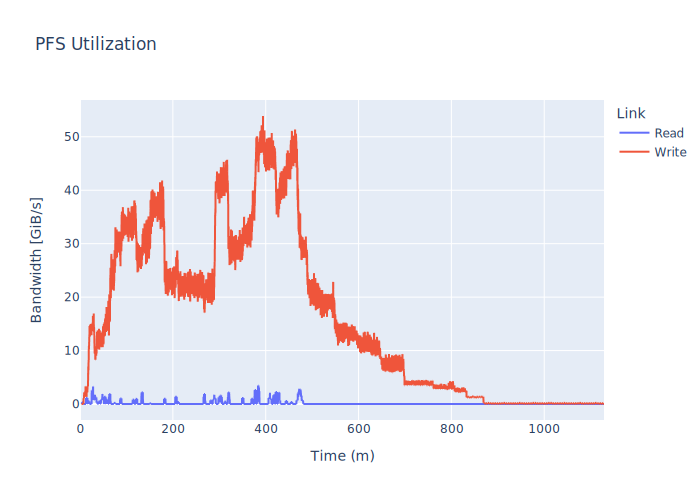

In [16]:
plot_pfs_utilization(os.path.join(output_dir, 'pfs_utilization.csv'), window=200)

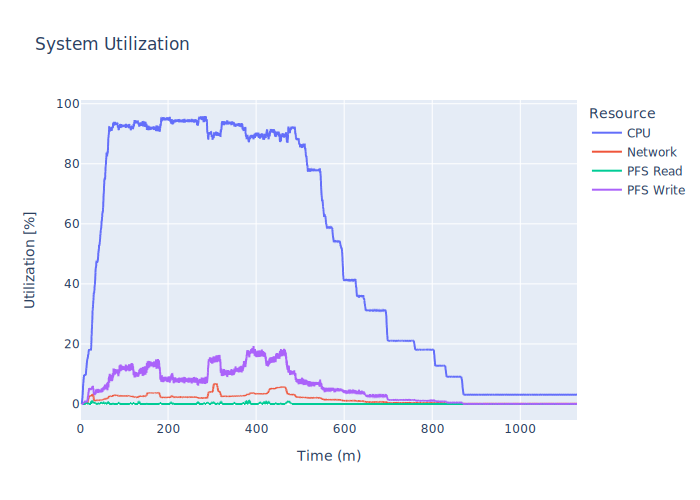

In [17]:
plot_utilization(os.path.join(output_dir, 'cpu_utilization.csv'),
                 os.path.join(output_dir, 'network_activity.csv'),
                 os.path.join(output_dir, 'pfs_utilization.csv'),
                 window=200)

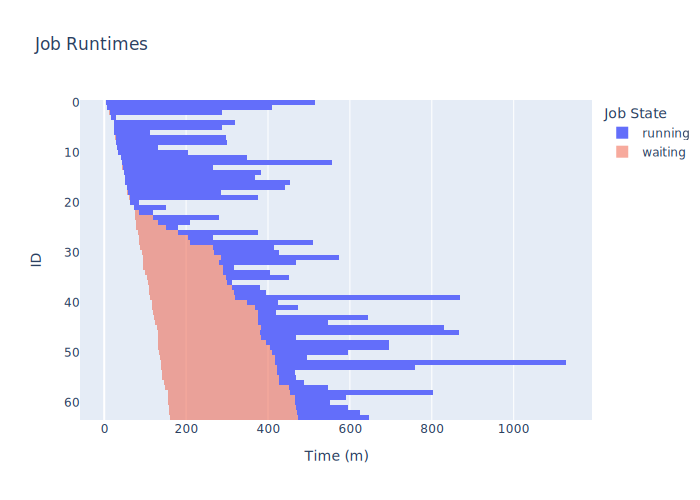

In [18]:
plot_jobs_gantt(os.path.join(output_dir, 'job_statistics.csv'))

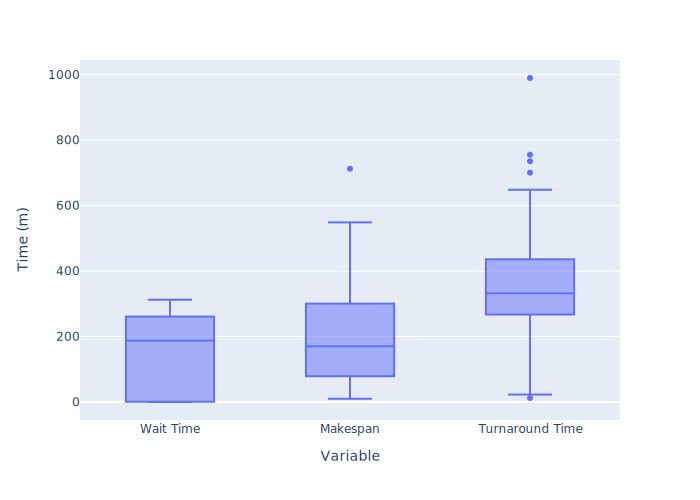

In [19]:
plot_jobs_box(os.path.join(output_dir, 'job_statistics.csv'))

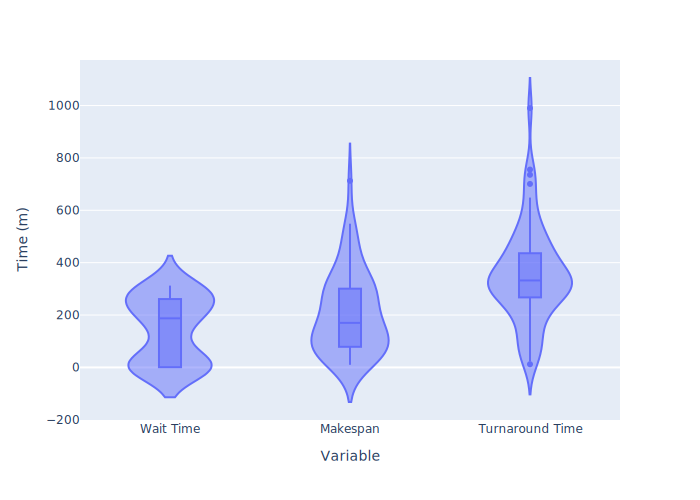

In [20]:
plot_jobs_violin(os.path.join(output_dir, 'job_statistics.csv'))